### fit and evaluate an AR model

/Users/jai/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Test RMSE: 7.259


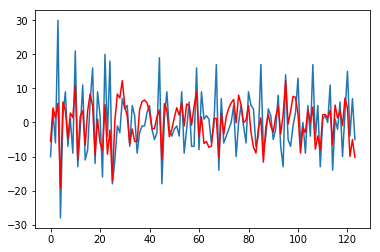

In [1]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import numpy
from math import sqrt

# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)

# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat

series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# split dataset
X = difference(series.values)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]
# train autoregression
model = AR(train)
model_fit = model.fit(maxlag=6, disp=False)
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
	yhat = predict(coef, history)
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### fit an AR model and save the whole model to file

In [2]:
from pandas import read_csv
from statsmodels.tsa.ar_model import AR
import numpy

# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)

# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = difference(series.values)
# fit model
model = AR(X)
model_fit = model.fit(maxlag=6, disp=False)
# save model to file
model_fit.save('ar_model.pkl')
# save the differenced dataset
numpy.save('ar_data.npy', X)
# save the last ob
numpy.save('ar_obs.npy', [series.values[-1]])

### load the AR model from file

In [3]:
from statsmodels.tsa.ar_model import ARResults
import numpy
loaded = ARResults.load('ar_model.pkl')
print(loaded.params)
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
print(last_ob)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[50]


### fit an AR model and manually save coefficients to file


In [4]:
from pandas import read_csv
from statsmodels.tsa.ar_model import AR
import numpy

# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)

# load dataset
series = read_csv('daily-total-female-births.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
X = difference(series.values)
# fit model
window_size = 6
model = AR(X)
model_fit = model.fit(maxlag=window_size, disp=False)
# save coefficients
coef = model_fit.params
numpy.save('man_model.npy', coef)
# save lag
lag = X[-window_size:]
numpy.save('man_data.npy', lag)
# save the last ob
numpy.save('man_obs.npy', [series.values[-1]])

### load the manually saved model from file

In [5]:
import numpy
coef = numpy.load('man_model.npy')
print(coef)
lag = numpy.load('man_data.npy')
print(lag)
last_ob = numpy.load('man_obs.npy')
print(last_ob)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[-10   3  15  -4   7  -5]
[50]


### load AR model from file and make a one-step prediction

In [6]:
from statsmodels.tsa.ar_model import ARResults
import numpy
# load model
model = ARResults.load('ar_model.pkl')
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
# make prediction
predictions = model.predict(start=len(data), end=len(data))
# transform prediction
yhat = predictions[0] + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 46.755211


### load a coefficients and from file and make a manual prediction

In [7]:
import numpy

def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat

# load model
coef = numpy.load('man_model.npy')
lag = numpy.load('man_data.npy')
last_ob = numpy.load('man_obs.npy')
# make prediction
prediction = predict(coef, lag)
# transform prediction
yhat = prediction + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 46.755211


### update the data for the AR model with a new obs

In [8]:
import numpy
# get real observation
observation = 48
# load the saved data
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
# update and save differenced observation
diffed = observation - last_ob[0]
data = numpy.append(data, [diffed], axis=0)
numpy.save('ar_data.npy', data)
# update and save real observation
last_ob[0] = observation
numpy.save('ar_obs.npy', last_ob)

### update the data for the manual model with a new obs

In [9]:
import numpy
# get real observation
observation = 48
# update and save differenced observation
lag = numpy.load('man_data.npy')
last_ob = numpy.load('man_obs.npy')
diffed = observation - last_ob[0]
lag = numpy.append(lag[1:], [diffed], axis=0)
numpy.save('man_data.npy', lag)
# update and save real observation
last_ob[0] = observation
numpy.save('man_obs.npy', last_ob)